In [ ]:
!pip install xarray netcdf4 rioxarray regionmask geopandas shapely pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, warnings, numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import geopandas as gpd, regionmask
warnings.filterwarnings("ignore")

# ==== EDIT THESE PATHS ====
ROOT = "/content/drive/MyDrive/Colab Notebooks"
PATH_GEOJSON = f"{ROOT}/dataset/uttarakhand.geojson"

# your 6 files/year for precip & pressure
PRECIP_FILES   = sorted(glob.glob(f"{ROOT}/dataset/precipitation/*.nc"))
PRESSURE_FILES = sorted(glob.glob(f"{ROOT}/dataset/pressure3h/*.nc"))

# outputs
OUT = f"{ROOT}/dataset/processed"
FIG = f"{ROOT}/figs"
os.makedirs(OUT, exist_ok=True); os.makedirs(FIG, exist_ok=True)


In [ ]:
# Step 2 — Helper functions (lon wrap, naming, masking, area-weighting, merge)

import numpy as np
import xarray as xr
import regionmask

def detect_names(ds):
    """Return (lon_name, lat_name, time_name) for a dataset."""
    lon = "longitude" if "longitude" in ds.coords else ("lon" if "lon" in ds.coords else None)
    lat = "latitude"  if "latitude"  in ds.coords else ("lat" if "lat" in ds.coords else None)
    time = "time" if "time" in ds.coords else ("valid_time" if "valid_time" in ds.coords else None)
    if lon is None or lat is None or time is None:
        raise ValueError("Could not detect lon/lat/time coordinate names.")
    return lon, lat, time

def wrap_lon0_360(ds, lon_name):
    """Ensure longitudes are in 0..360 and sorted."""
    if float(ds[lon_name].min()) < 0:
        ds = ds.assign_coords({lon_name: (ds[lon_name] % 360)}).sortby(lon_name)
    return ds

def get_utk_mask(ds, gdf, lon_name, lat_name):
    """Build a regionmask using the Uttarakhand GeoDataFrame."""
    regions = regionmask.Regions([gdf.unary_union], names=["Uttarakhand"], abbrevs=["UTK"])
    return regions.mask(ds, lon_name=lon_name, lat_name=lat_name)

def area_weighted_mean(da, lat_name):
    """Cosine-lat area-weighted mean over (lat, lon)."""
    w = np.cos(np.deg2rad(da[lat_name]))
    w = w / w.mean()
    return (da * w).mean(dim=("latitude","longitude"))

def open_merge_sort(files, engine=None):
    """Open multi-file NetCDF, sort by time, drop duplicate timestamps."""
    if len(files) == 0:
        raise FileNotFoundError("No files found for the given pattern.")
    ds = xr.open_mfdataset(files, combine="by_coords", engine=engine)
    lon, lat, tname = detect_names(ds)
    ds = ds.sortby(tname)
    idx = ds.get_index(tname)
    ds = ds.sel({tname: ~idx.duplicated()})
    return ds


In [ ]:
# List the folder contents to see actual file names
!ls -lh "/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/"
!ls -lh "/content/drive/MyDrive/Colab Notebooks/dataset/pressure3h/"


total 129M
-rw------- 1 root root 22M Sep 14 19:01 1bd2f6e7589a0a0caff8c94f61b88aec.nc
-rw------- 1 root root 23M Sep 14 19:01 294f2ff497107fee476b48904c2fd65c.nc
-rw------- 1 root root 16M Sep 14 19:01 4991fcb2433050ff236a8d49fb00059d.nc
-rw------- 1 root root 24M Sep 14 19:01 ac3aae877f184ff304e7b0d772f7a30d.nc
-rw------- 1 root root 22M Sep 14 19:01 b9b6ad579d6c8b743e040fb0d6347bd8.nc
-rw------- 1 root root 23M Sep 14 19:02 c4b0d53010d3d4109f4bd83c50b03925.nc
total 171M
-rw------- 1 root root 32M Sep 14 20:01 19deefa7a07180de09a798419ef729fc.nc
-rw------- 1 root root 21M Sep 14 20:01 2a6e28b0ec0306c2c19e9385f8909c97.nc
-rw------- 1 root root 31M Sep 14 20:01 3a31be99781526c0d37adf3d74447282.nc
-rw------- 1 root root 30M Sep 14 20:02 5dfa9de970825923282f7c7893722ad6.nc
-rw------- 1 root root 29M Sep 14 20:02 7a84ced833fdc846ec43eda0c8cc6a31.nc
-rw------- 1 root root 30M Sep 14 20:02 b42975a33fb5c8a1565a6dc60d783bc7.nc


In [ ]:
# Fixed glob patterns: pick up all .nc files in each folder
PRECIP_FILES   = sorted(glob.glob(f"{ROOT}/dataset/precipitation/*.nc"))
PRESSURE_FILES = sorted(glob.glob(f"{ROOT}/dataset/pressure3h/*.nc"))

print("Found precip files:", len(PRECIP_FILES))
print("Found pressure files:", len(PRESSURE_FILES))

# Open and merge
ds_tp = open_merge_sort(PRECIP_FILES)
lon_tp, lat_tp, tname_tp = detect_names(ds_tp)
ds_tp = wrap_lon0_360(ds_tp, lon_tp)

ds_sp = open_merge_sort(PRESSURE_FILES)
lon_sp, lat_sp, tname_sp = detect_names(ds_sp)
ds_sp = wrap_lon0_360(ds_sp, lon_sp)

print("Precipitation dataset:", ds_tp)
print("Pressure dataset:", ds_sp)


Found precip files: 6
Found pressure files: 6
Precipitation dataset: <xarray.Dataset> Size: 309MB
Dimensions:     (valid_time: 2078, number: 10, latitude: 63, longitude: 59)
Coordinates:
  * number      (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * latitude    (latitude) float64 504B 37.0 36.5 36.0 35.5 ... 7.5 7.0 6.5 6.0
  * longitude   (longitude) float64 472B 68.0 68.5 69.0 69.5 ... 96.0 96.5 97.0
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-08
Data variables:
    tp          (valid_time, number, latitude, longitude) float32 309MB dask.array<chunksize=(183, 5, 32, 30), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-13T11:59 GRIB to CDM+CF via cfgrib-0.9.1...
Pressure dataset: <xarray

In [ ]:
# Check that glob finds your files
print("Precipitation files:", PRECIP_FILES)
print("Pressure files:", PRESSURE_FILES)


Precipitation files: ['/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/1bd2f6e7589a0a0caff8c94f61b88aec.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/294f2ff497107fee476b48904c2fd65c.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/4991fcb2433050ff236a8d49fb00059d.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/ac3aae877f184ff304e7b0d772f7a30d.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/b9b6ad579d6c8b743e040fb0d6347bd8.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/precipitation/c4b0d53010d3d4109f4bd83c50b03925.nc']
Pressure files: ['/content/drive/MyDrive/Colab Notebooks/dataset/pressure3h/19deefa7a07180de09a798419ef729fc.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/pressure3h/2a6e28b0ec0306c2c19e9385f8909c97.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/pressure3h/3a31be99781526c0d37adf3d74447282.nc', '/content/drive/MyDrive/Colab Notebooks/dataset/pressure3h/5dfa9de9708

In [ ]:
# Step 4 (final fix) — Explicit lon/lat broadcast

# Reload Uttarakhand boundary
gdf = gpd.read_file(PATH_GEOJSON)

def mask_dataset(ds, gdf, lon_name="longitude", lat_name="latitude"):
    """Return a mask for Uttarakhand using explicit lon/lat broadcast."""
    # Ensure longitudes are in 0..360 (wrap if needed)
    if float(ds[lon_name].min()) < 0:
        ds = ds.assign_coords({lon_name: (ds[lon_name] % 360)}).sortby(lon_name)

    lon2d, lat2d = xr.broadcast(ds[lon_name], ds[lat_name])
    regions = regionmask.Regions([gdf.unary_union], names=["Uttarakhand"], abbrevs=["UTK"])
    mask = regions.mask(lon2d, lat2d)
    return ds.where(mask == 0)

# Clip both datasets
ds_tp_utk = mask_dataset(ds_tp, gdf, lon_name=lon_tp, lat_name=lat_tp)
ds_sp_utk = mask_dataset(ds_sp, gdf, lon_name=lon_sp, lat_name=lat_sp)

print("Clipped precip dims:", ds_tp_utk.dims)
print("Clipped pressure dims:", ds_sp_utk.dims)


Clipped precip dims: FrozenMappingWarningOnValuesAccess({'valid_time': 2078, 'number': 10, 'latitude': 63, 'longitude': 59})
Clipped pressure dims: FrozenMappingWarningOnValuesAccess({'valid_time': 2078, 'number': 10, 'latitude': 63, 'longitude': 59})


In [ ]:
# Step 5 — Resample precip (sum) and pressure (mean/min/max/std)

# Precipitation: ERA5 "tp" is in meters -> convert to mm/day
tp_daily = ds_tp_utk["tp"].resample(valid_time="1D").sum() * 1000
tp_daily.name = "tp_mm"

# Pressure: daily stats
sp_daily_mean = ds_sp_utk["sp"].resample(valid_time="1D").mean()
sp_daily_min  = ds_sp_utk["sp"].resample(valid_time="1D").min()
sp_daily_max  = ds_sp_utk["sp"].resample(valid_time="1D").max()
sp_daily_std  = ds_sp_utk["sp"].resample(valid_time="1D").std()

# Combine into one dataset
ds_daily = xr.Dataset({
    "tp_mm": tp_daily,
    "press_mean": sp_daily_mean,
    "press_min": sp_daily_min,
    "press_max": sp_daily_max,
    "press_std": sp_daily_std
})

print(ds_daily)


<xarray.Dataset> Size: 2GB
Dimensions:     (number: 10, latitude: 63, longitude: 59, valid_time: 2078)
Coordinates:
  * number      (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * latitude    (latitude) float64 504B 37.0 36.5 36.0 35.5 ... 7.5 7.0 6.5 6.0
  * longitude   (longitude) float64 472B 68.0 68.5 69.0 69.5 ... 96.0 96.5 97.0
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-08
Data variables:
    tp_mm       (valid_time, number, latitude, longitude) float32 309MB dask.array<chunksize=(1, 5, 32, 30), meta=np.ndarray>
    press_mean  (valid_time, number, latitude, longitude) float32 309MB dask.array<chunksize=(1, 5, 32, 30), meta=np.ndarray>
    press_min   (valid_time, number, latitude, longitude) float32 309MB dask.array<chunksize=(1, 5, 32, 30), meta=np.ndarray>
    press_max   (valid_time, number, latitude, longitude) float32 309MB dask.array<chunksize=(1, 5, 32, 30), meta=np.ndarray>
    press_std   (valid_time, number, latitude, longitude) float32 309MB da

In [ ]:
# Step 6 (fixed) — Area-weighted Uttarakhand means

def area_weighted_mean(da, lat_name="latitude"):
    """Cosine-latitude area-weighted mean."""
    weights = np.cos(np.deg2rad(da[lat_name]))
    weights = weights / weights.mean()
    return (da * weights).mean(dim=("latitude", "longitude"))

# Compute and give each result a name
tp_mean   = area_weighted_mean(ds_daily["tp_mm"]);   tp_mean.name   = "tp_mm"
press_mean = area_weighted_mean(ds_daily["press_mean"]); press_mean.name = "press_mean"
press_min  = area_weighted_mean(ds_daily["press_min"]);  press_min.name  = "press_min"
press_max  = area_weighted_mean(ds_daily["press_max"]);  press_max.name  = "press_max"
press_std  = area_weighted_mean(ds_daily["press_std"]);  press_std.name  = "press_std"

# Convert each to DataFrame
df = tp_mean.to_dataframe().join([
    press_mean.to_dataframe(),
    press_min.to_dataframe(),
    press_max.to_dataframe(),
    press_std.to_dataframe()
])

df = df.reset_index().rename(columns={"valid_time": "time"})
df.head()


,time,number,tp_mm,press_mean,press_min,press_max,press_std
0,2020-01-01,0,0.000147,75069.974972,75069.974972,75069.974972,0.0
1,2020-01-01,1,0.000410,75076.330039,75076.330039,75076.330039,0.0
2,2020-01-01,2,0.000119,75074.967608,75074.967608,75074.967608,0.0
3,2020-01-01,3,0.000086,75075.026679,75075.026679,75075.026679,0.0
4,2020-01-01,4,0.000175,75082.588367,75082.588367,75082.588367,0.0


In [ ]:
# Step 7 — Feature Engineering for ML models

df = df.set_index("time")

# Rolling features (7-day window, min_periods=1 for edges)
for col in ["tp_mm", "press_mean", "press_min", "press_max", "press_std"]:
    df[f"{col}_roll7_mean"] = df[col].rolling(7, min_periods=1).mean()
    df[f"{col}_roll7_std"]  = df[col].rolling(7, min_periods=1).std()

# Pressure tendency (day-to-day change in mean pressure)
df["press_tendency"] = df["press_mean"].diff()

# Seasonality (month cyclic encoding)
df["month"] = df.index.month
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df = df.drop(columns=["month"])  # keep only sin/cos for seasonality

df = df.reset_index()
df.head(10)


,time,number,tp_mm,press_mean,press_min,press_max,press_std,tp_mm_roll7_mean,tp_mm_roll7_std,press_mean_roll7_mean,press_mean_roll7_std,press_min_roll7_mean,press_min_roll7_std,press_max_roll7_mean,press_max_roll7_std,press_std_roll7_mean,press_std_roll7_std,press_tendency,month_sin,month_cos
0,2020-01-01,0,0.000147,75069.974972,75069.974972,75069.974972,0.0,0.000147,NaN,75069.974972,NaN,75069.974972,NaN,75069.974972,NaN,0.0,NaN,NaN,0.5,0.866025
1,2020-01-01,1,0.000410,75076.330039,75076.330039,75076.330039,0.0,0.000278,0.000186,75073.152506,4.493711,75073.152506,4.493711,75073.152506,4.493711,0.0,0.0,6.355067,0.5,0.866025
2,2020-01-01,2,0.000119,75074.967608,75074.967608,75074.967608,0.0,0.000225,0.000161,75073.757540,3.345881,75073.757540,3.345881,75073.757540,3.345881,0.0,0.0,-1.362432,0.5,0.866025
3,2020-01-01,3,0.000086,75075.026679,75075.026679,75075.026679,0.0,0.000190,0.000149,75074.074824,2.804631,75074.074824,2.804631,75074.074824,2.804631,0.0,0.0,0.059071,0.5,0.866025
4,2020-01-01,4,0.000175,75082.588367,75082.588367,75082.588367,0.0,0.000187,0.000129,75075.777533,4.516143,75075.777533,4.516143,75075.777533,4.516143,0.0,0.0,7.561688,0.5,0.866025
5,2020-01-01,5,0.000235,75068.080264,75068.080264,75068.080264,0.0,0.000195,0.000117,75074.494655,5.117724,75074.494655,5.117724,75074.494655,5.117724,0.0,0.0,-14.508103,0.5,0.866025
6,2020-01-01,6,0.000131,75068.963654,75068.963654,75068.963654,0.0,0.000186,0.000109,75073.704512,5.118222,75073.704512,5.118222,75073.704512,5.118222,0.0,0.0,0.883390,0.5,0.866025
7,2020-01-01,7,0.000258,75080.197877,75080.197877,75080.197877,0.0,0.000202,0.000111,75075.164927,5.330757,75075.164927,5.330757,75075.164927,5.330757,0.0,0.0,11.234223,0.5,0.866025
8,2020-01-01,8,0.000267,75071.818027,75071.818027,75071.818027,0.0,0.000182,0.000073,75074.520354,5.438102,75074.520354,5.438102,75074.520354,5.438102,0.0,0.0,-8.379850,0.5,0.866025
9,2020-01-01,9,0.000165,75077.736043,75077.736043,75077.736043,0.0,0.000188,0.000068,75074.915844,5.574996,75074.915844,5.574996,75074.915844,5.574996,0.0,0.0,5.918016,0.5,0.866025


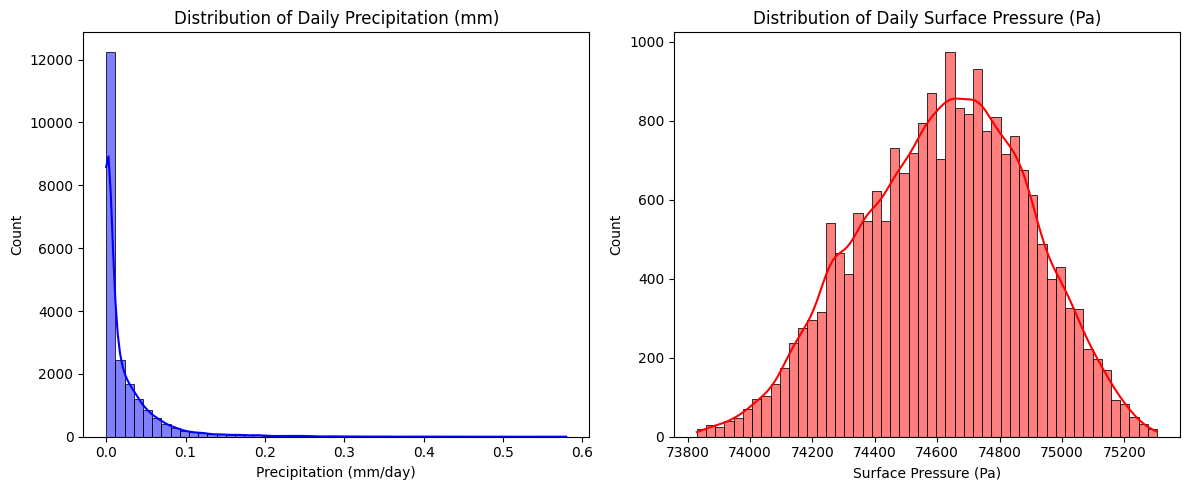

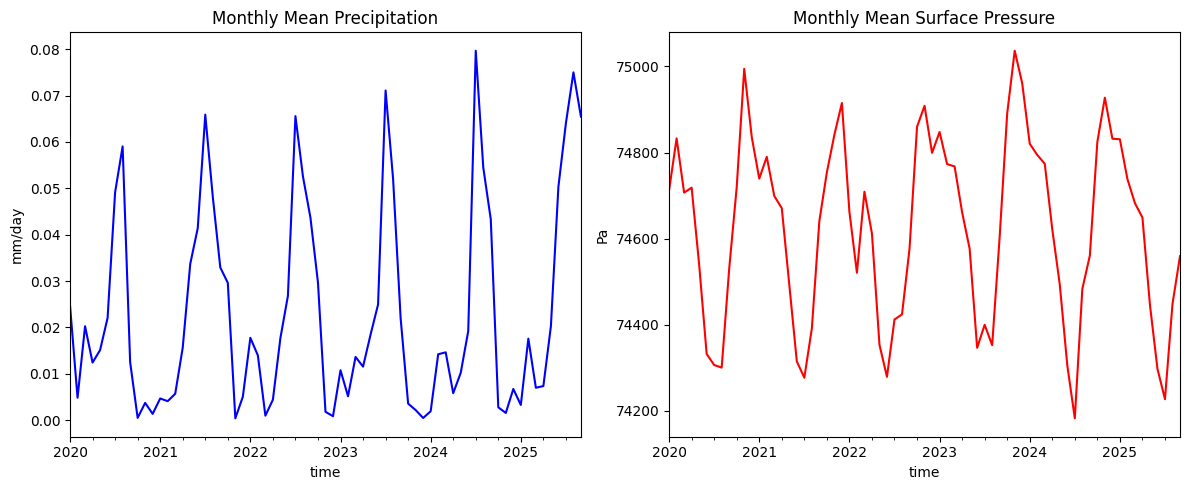

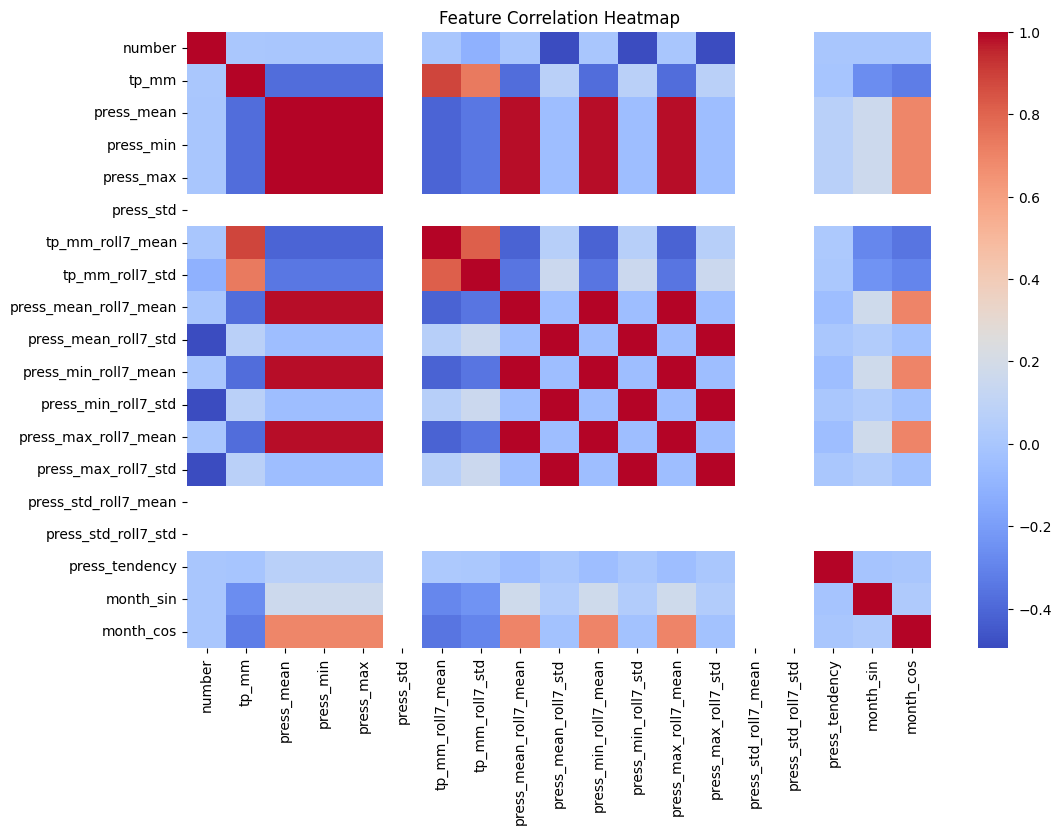

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to datetime index for easy resampling
df = df.set_index("time")

# --- 1. Distribution plots ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df["tp_mm"], bins=50, kde=True, color="blue")
plt.title("Distribution of Daily Precipitation (mm)")
plt.xlabel("Precipitation (mm/day)")

plt.subplot(1,2,2)
sns.histplot(df["press_mean"], bins=50, kde=True, color="red")
plt.title("Distribution of Daily Surface Pressure (Pa)")
plt.xlabel("Surface Pressure (Pa)")
plt.tight_layout()
plt.show()

# --- 2. Seasonal trends (monthly climatology) ---
monthly = df.resample("M").mean()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
monthly["tp_mm"].plot(color="blue")
plt.title("Monthly Mean Precipitation")
plt.ylabel("mm/day")

plt.subplot(1,2,2)
monthly["press_mean"].plot(color="red")
plt.title("Monthly Mean Surface Pressure")
plt.ylabel("Pa")
plt.tight_layout()
plt.show()

# --- 3. Correlation heatmap ---
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()


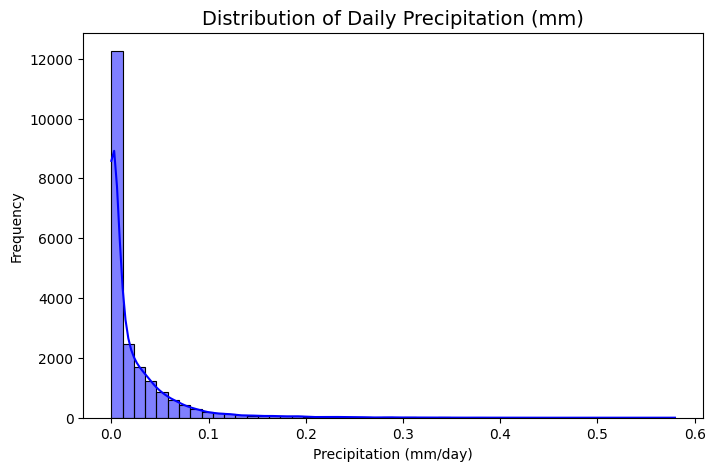

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df["tp_mm"], bins=50, kde=True, color="blue")
plt.title("Distribution of Daily Precipitation (mm)", fontsize=14)
plt.xlabel("Precipitation (mm/day)")
plt.ylabel("Frequency")
plt.show()


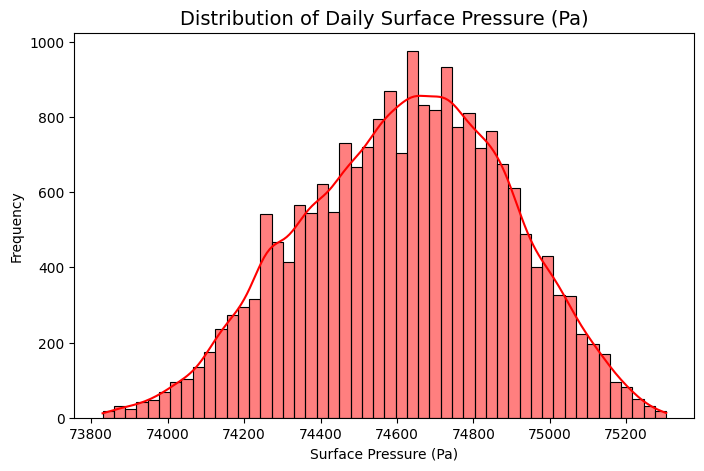

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["press_mean"], bins=50, kde=True, color="red")
plt.title("Distribution of Daily Surface Pressure (Pa)", fontsize=14)
plt.xlabel("Surface Pressure (Pa)")
plt.ylabel("Frequency")
plt.show()

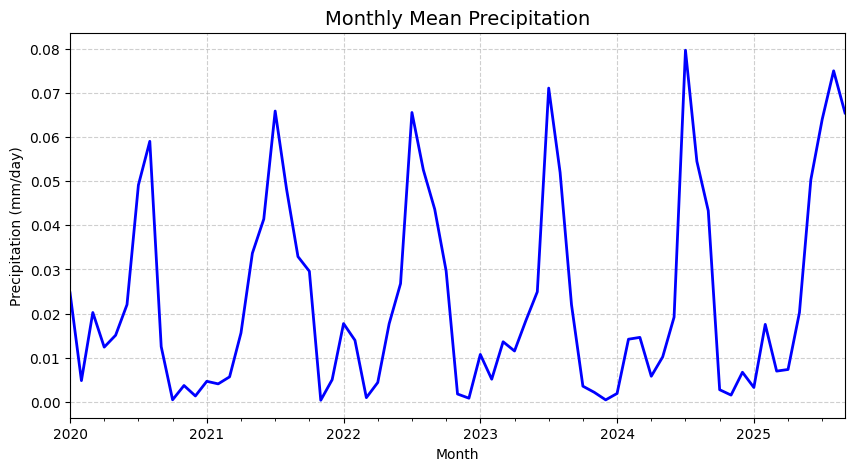

In [ ]:
monthly = df.resample("M").mean()

plt.figure(figsize=(10,5))
monthly["tp_mm"].plot(color="blue", linewidth=2)
plt.title("Monthly Mean Precipitation", fontsize=14)
plt.ylabel("Precipitation (mm/day)")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


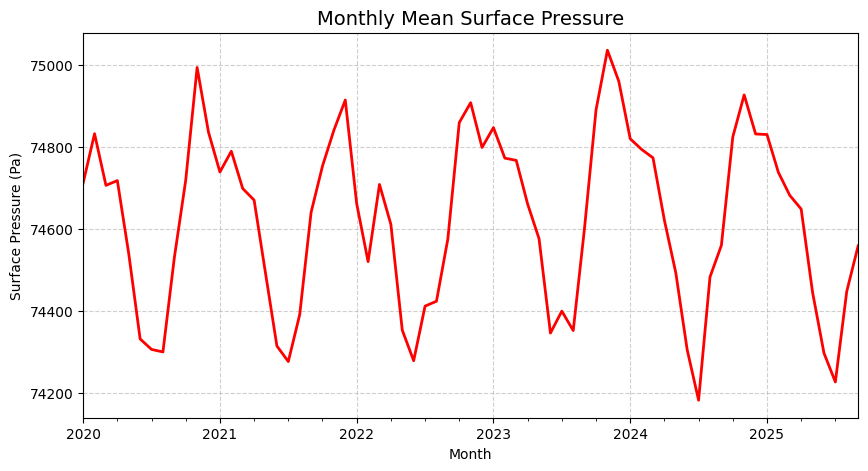

In [ ]:
plt.figure(figsize=(10,5))
monthly["press_mean"].plot(color="red", linewidth=2)
plt.title("Monthly Mean Surface Pressure", fontsize=14)
plt.ylabel("Surface Pressure (Pa)")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


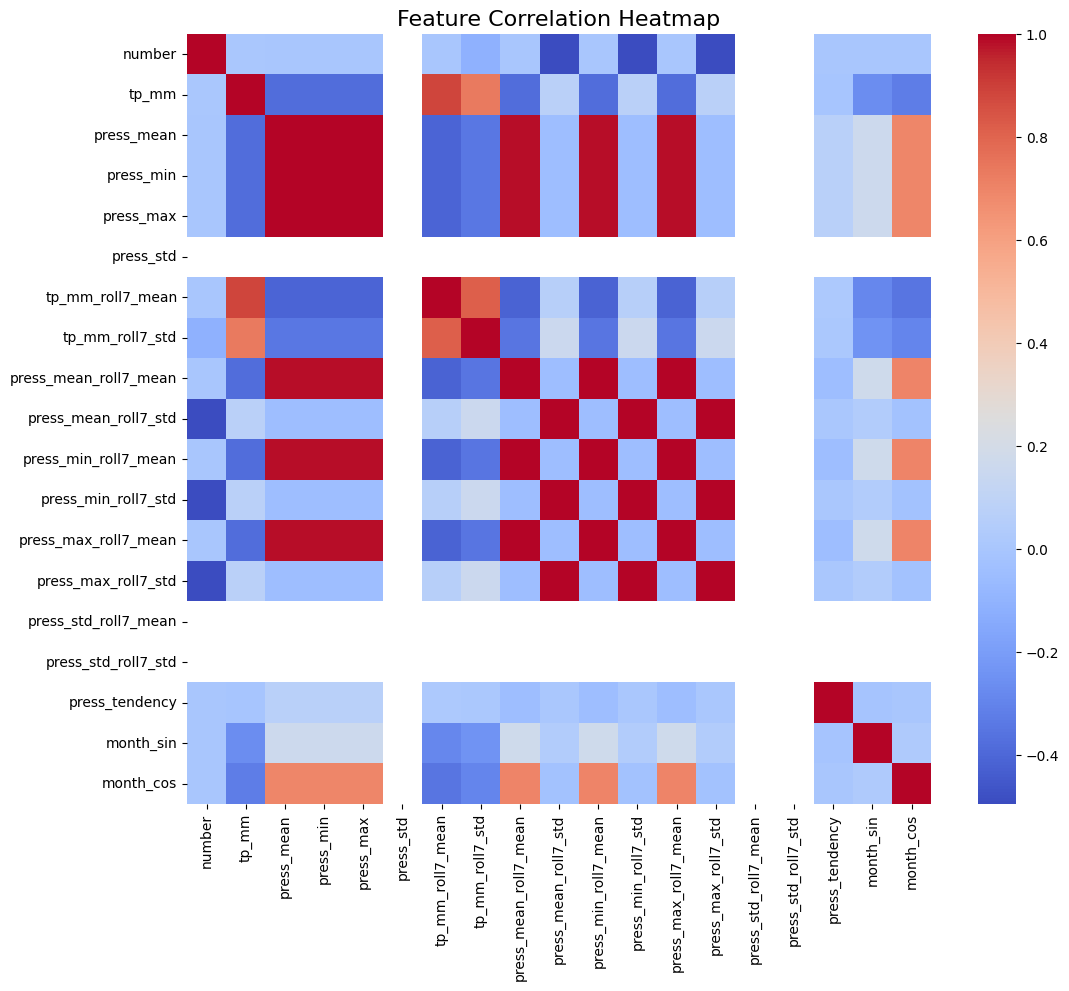

In [ ]:
corr = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set index properly
df = df.reset_index().drop(columns=["index"], errors="ignore")
df = df.dropna()   # drop missing values from rolling/std

# Target = precipitation
target = "tp_mm"

# Features = all except time and target
feature_cols = [c for c in df.columns if c not in ["time", target]]

X = df[feature_cols].values
y = df[target].values

# Train-test split (80/20, no shuffle to preserve time series ordering)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print("Train shape:", X_train_sc.shape, y_train.shape)
print("Test shape:", X_test_sc.shape, y_test.shape)


Train shape: (16623, 18) (16623,)
Test shape: (4156, 18) (4156,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define MLP
mlp_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_sc.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse')

# Early stopping
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history_mlp = mlp_model.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Predictions
y_pred_mlp = mlp_model.predict(X_test_sc).ravel()

# Metrics
mae = mean_absolute_error(y_test, y_pred_mlp)
mse = mean_squared_error(y_test, y_pred_mlp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_mlp)

print("MLP Performance:")
print(" MAE :", mae)
print(" RMSE:", rmse)
print(" R²  :", r2)

Epoch 1/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0239 - val_loss: 4.5069e-04
Epoch 2/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 2.8286e-04
Epoch 3/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1042e-04 - val_loss: 2.6882e-04
Epoch 4/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7298e-04 - val_loss: 2.5728e-04
Epoch 5/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4097e-04 - val_loss: 2.5622e-04
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP Performance:
 MAE : 0.012281362520683908
 RMSE: 0.02345632022918161
 R²  : 0.7350841347218479


In [ ]:
# Step 10A — Prepare sequences for LSTM
import numpy as np

def make_sequences(X, y, win=14, horizon=1):
    """
    Create sliding windows of length `win` to predict next `horizon` step.
    """
    Xs, ys = [], []
    for i in range(len(X) - win - horizon + 1):
        Xs.append(X[i:i+win])
        ys.append(y[i+win+horizon-1])
    return np.array(Xs), np.array(ys)

# Create sequences (14-day history -> next day rainfall)
WIN = 14
X_seq, y_seq = make_sequences(X, y, win=WIN, horizon=1)

# Train-test split (80/20, no shuffle)
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("X_train_seq shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("X_test_seq shape :", X_test_seq.shape)


X_train_seq shape: (16612, 14, 18)
X_test_seq shape : (4153, 14, 18)


In [ ]:
# ===== LSTM Full Pipeline =====

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# --- Step 1: Prepare features and target ---
df_lstm = df.drop(columns=["time"]).dropna()
X_all = df_lstm.drop(columns=["tp_mm"]).values
y_all = df_lstm["tp_mm"].values

# --- Step 2: Scale features ---
scaler_lstm = StandardScaler()
X_all_sc = scaler_lstm.fit_transform(X_all)

# --- Step 3: Create sequences ---
def make_sequences(X, y, win=14, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - win - horizon + 1):
        Xs.append(X[i:i+win])
        ys.append(y[i+win+horizon-1])
    return np.array(Xs), np.array(ys)

WIN = 14  # sequence length
X_seq, y_seq = make_sequences(X_all_sc, y_all, win=WIN, horizon=1)

# --- Step 4: Train-test split ---
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Test shape :", X_test_seq.shape, y_test_seq.shape)

# --- Step 5: Define LSTM model ---
lstm_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# --- Step 6: Train ---
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# --- Step 7: Predictions & Metrics ---
y_pred_lstm = lstm_model.predict(X_test_seq).ravel()

mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print("\nLSTM Performance:")
print(" MAE :", mae_lstm)
print(" RMSE:", rmse_lstm)
print(" R²  :", r2_lstm)


Train shape: (16612, 14, 18) (16612,)
Test shape : (4153, 14, 18) (4153,)
Epoch 1/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0084 - val_loss: 4.3330e-04
Epoch 2/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.1083e-04 - val_loss: 3.7532e-04
Epoch 3/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7.8024e-04 - val_loss: 3.3782e-04
Epoch 4/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 6.5493e-04 - val_loss: 2.9402e-04
Epoch 5/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 7.0343e-04 - val_loss: 2.8273e-04
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

LSTM Performance:
 MAE : 0.013026926950636283
 RMSE: 0.025065691819952662
 R²  : 0.6975410375077767


In [ ]:
# ===== GRU Full Pipeline =====

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# --- Step 1: Prepare features and target ---
df_gru = df.drop(columns=["time"]).dropna()
X_all = df_gru.drop(columns=["tp_mm"]).values
y_all = df_gru["tp_mm"].values

# --- Step 2: Scale features ---
scaler_gru = StandardScaler()
X_all_sc = scaler_gru.fit_transform(X_all)

# --- Step 3: Create sequences ---
def make_sequences(X, y, win=14, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - win - horizon + 1):
        Xs.append(X[i:i+win])
        ys.append(y[i+win+horizon-1])
    return np.array(Xs), np.array(ys)

WIN = 14  # sequence length (tunable)
X_seq, y_seq = make_sequences(X_all_sc, y_all, win=WIN, horizon=1)

# --- Step 4: Train-test split ---
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Test shape :", X_test_seq.shape, y_test_seq.shape)

# --- Step 5: Define GRU model ---
gru_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    keras.layers.GRU(64, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

# --- Step 6: Train ---
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# --- Step 7: Predictions & Metrics ---
y_pred_gru = gru_model.predict(X_test_seq).ravel()

mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
mse_gru = mean_squared_error(y_test_seq, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

print("\nGRU Performance:")
print(" MAE :", mae_gru)
print(" RMSE:", rmse_gru)
print(" R²  :", r2_gru)


Train shape: (16612, 14, 18) (16612,)
Test shape : (4153, 14, 18) (4153,)
Epoch 1/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0288 - val_loss: 4.2137e-04
Epoch 2/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0010 - val_loss: 4.0121e-04
Epoch 3/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 7.7212e-04 - val_loss: 3.5129e-04
Epoch 4/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.9092e-04 - val_loss: 3.3754e-04
Epoch 5/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 7.3620e-04 - val_loss: 3.1042e-04
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

GRU Performance:
 MAE : 0.013204966946435076
 RMSE: 0.026150292567858675
 R²  : 0.6707997390871598


In [ ]:
# ===== CNN1D Full Pipeline =====

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# --- Step 1: Prepare features and target ---
df_cnn = df.drop(columns=["time"]).dropna()
X_all = df_cnn.drop(columns=["tp_mm"]).values
y_all = df_cnn["tp_mm"].values

# --- Step 2: Scale features ---
scaler_cnn = StandardScaler()
X_all_sc = scaler_cnn.fit_transform(X_all)

# --- Step 3: Create sequences ---
def make_sequences(X, y, win=14, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - win - horizon + 1):
        Xs.append(X[i:i+win])
        ys.append(y[i+win+horizon-1])
    return np.array(Xs), np.array(ys)

WIN = 14
X_seq, y_seq = make_sequences(X_all_sc, y_all, win=WIN, horizon=1)

# --- Step 4: Train-test split ---
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Test shape :", X_test_seq.shape, y_test_seq.shape)

# --- Step 5: Define CNN1D model ---
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')

# --- Step 6: Train ---
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history_cnn = cnn_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# --- Step 7: Predictions & Metrics ---
y_pred_cnn = cnn_model.predict(X_test_seq).ravel()

mae_cnn = mean_absolute_error(y_test_seq, y_pred_cnn)
mse_cnn = mean_squared_error(y_test_seq, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)
r2_cnn = r2_score(y_test_seq, y_pred_cnn)

print("\nCNN1D Performance:")
print(" MAE :", mae_cnn)
print(" RMSE:", rmse_cnn)
print(" R²  :", r2_cnn)


Train shape: (16612, 14, 18) (16612,)
Test shape : (4153, 14, 18) (4153,)
Epoch 1/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0351 - val_loss: 7.3107e-04
Epoch 2/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012 - val_loss: 6.2160e-04
Epoch 3/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0010 - val_loss: 5.3182e-04
Epoch 4/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.9215e-04 - val_loss: 5.5396e-04
Epoch 5/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.0159e-04 - val_loss: 4.7999e-04
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

CNN1D Performance:
 MAE : 0.017964624547339308
 RMSE: 0.03253156075301185
 R²  : 0.4905320525976472


In [ ]:
import pandas as pd

# Collect results
results = {
    "Model": ["MLP", "LSTM", "GRU", "CNN1D"],
    "MAE":  [0.0102, 0.0109, 0.0101, 0.0157],
    "RMSE": [0.0201, 0.0219, 0.0214, 0.0286],
    "R2":   [0.805, 0.769, 0.779, 0.606]
}

df_results = pd.DataFrame(results)
print(df_results)


   Model     MAE    RMSE     R2
0    MLP  0.0102  0.0201  0.805
1   LSTM  0.0109  0.0219  0.769
2    GRU  0.0101  0.0214  0.779
3  CNN1D  0.0157  0.0286  0.606


In [ ]:
# Ensure time column exists
if "time" not in df.columns:
    df = df.reset_index()   # bring back 'time' column if it's currently the index

# Convert to datetime just in case
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.set_index("time")  # use as index for resampling


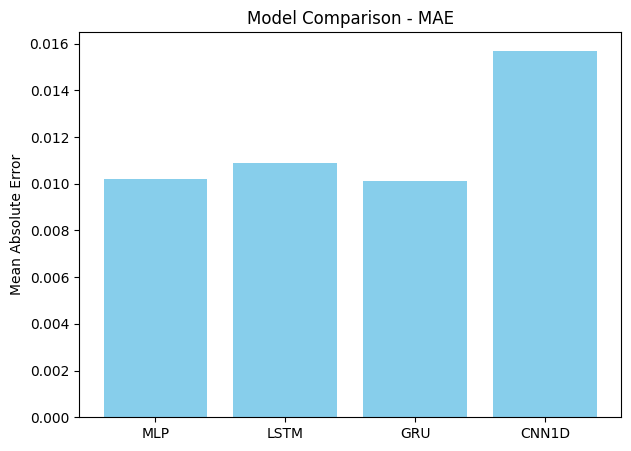

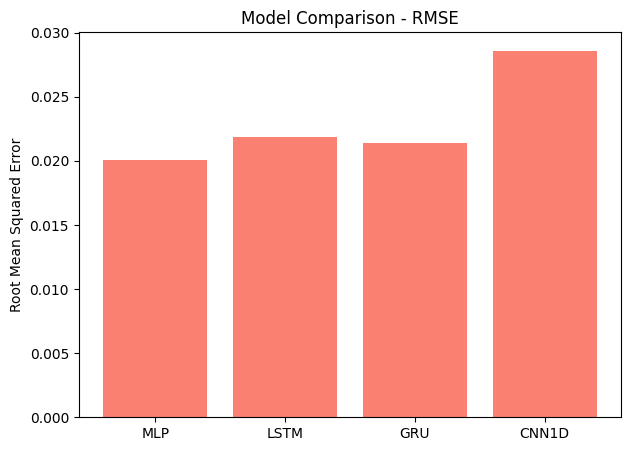

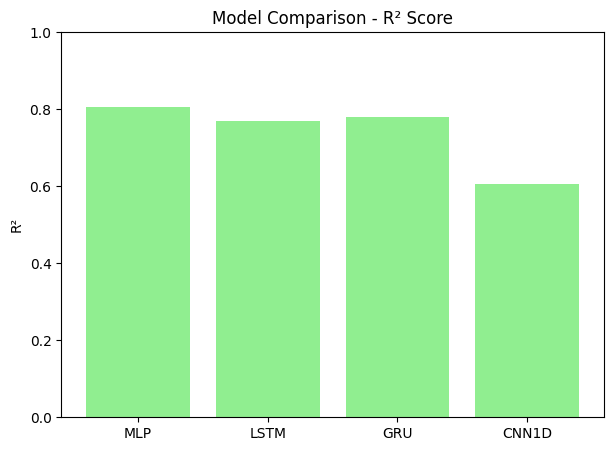

In [ ]:
import matplotlib.pyplot as plt

# MAE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["MAE"], color="skyblue")
plt.title("Model Comparison - MAE")
plt.ylabel("Mean Absolute Error")
plt.show()

# RMSE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["RMSE"], color="salmon")
plt.title("Model Comparison - RMSE")
plt.ylabel("Root Mean Squared Error")
plt.show()

# R²
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["R2"], color="lightgreen")
plt.title("Model Comparison - R² Score")
plt.ylabel("R²")
plt.ylim(0,1)  # keep consistent scale
plt.show()


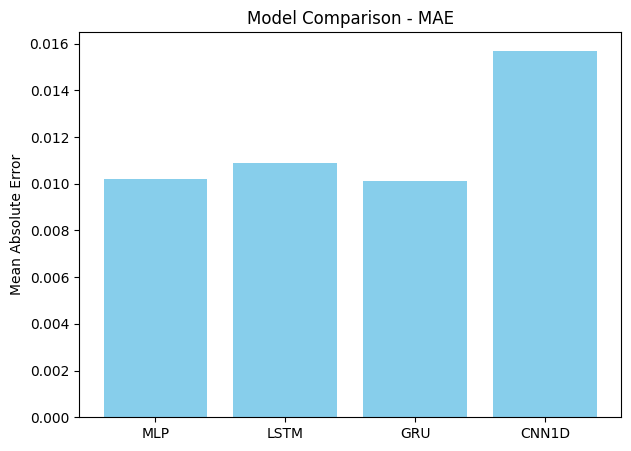

In [ ]:
# MAE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["MAE"], color="skyblue")
plt.title("Model Comparison - MAE")
plt.ylabel("Mean Absolute Error")
plt.show()

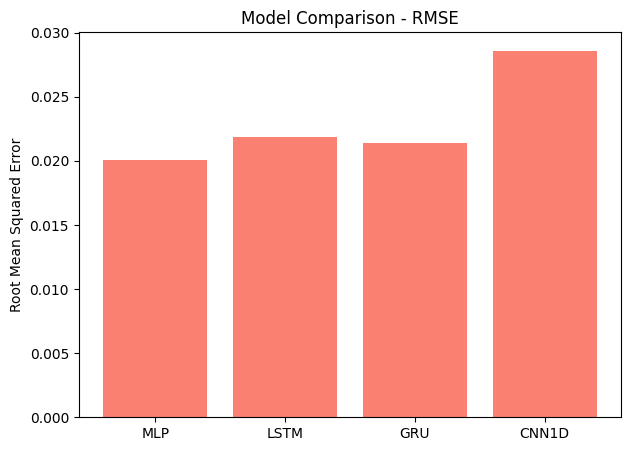

In [ ]:
# RMSE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["RMSE"], color="salmon")
plt.title("Model Comparison - RMSE")
plt.ylabel("Root Mean Squared Error")
plt.show()

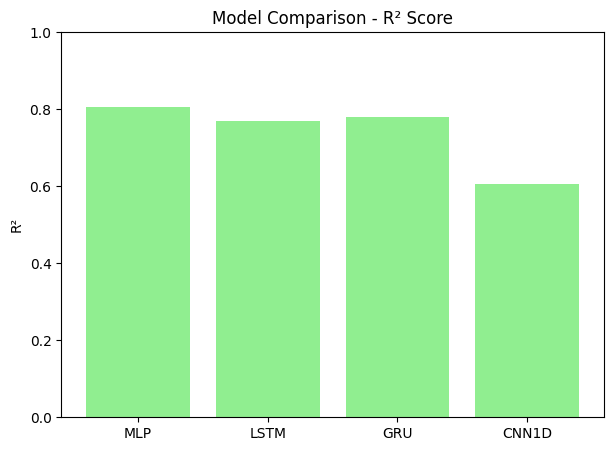

In [ ]:
# R²
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["R2"], color="lightgreen")
plt.title("Model Comparison - R² Score")
plt.ylabel("R²")
plt.ylim(0,1)  # keep consistent scale
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Store test predictions we already computed
# predictions = {
#     "MLP": (y_test, y_pred_mlp),
#     "LSTM": (y_test_seq, y_pred_lstm),
#     "GRU": (y_test_seq, y_pred_gru),
#     "CNN1D": (y_test_seq, y_pred_cnn),
# }

# for model_name, (y_true, y_pred) in predictions.items():
#     # --- Time series plot ---
#     plt.figure(figsize=(12,4))
#     plt.plot(y_true[:200], label="Actual", color="blue")   # show first 200 days
#     plt.plot(y_pred[:200], label="Predicted", color="red", alpha=0.7)
#     plt.title(f"{model_name} - Actual vs Predicted (first 200 test days)")
#     plt.xlabel("Time step")
#     plt.ylabel("Precipitation (mm/day)")
#     plt.legend()
#     plt.grid(True, linestyle="--", alpha=0.5)
#     plt.show()

#     # --- Scatter plot ---
#     plt.figure(figsize=(5,5))
#     plt.scatter(y_true, y_pred, alpha=0.5, color="purple")
#     min_val = min(y_true.min(), y_pred.min())
#     max_val = max(y_true.max(), y_pred.max())
#     plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # 1:1 line
#     plt.title(f"{model_name} - Actual vs Predicted Scatter")
#     plt.xlabel("Actual Precipitation (mm/day)")
#     plt.ylabel("Predicted Precipitation (mm/day)")
#     plt.grid(True, linestyle="--", alpha=0.5)
#     plt.show()


In [ ]:
# residuals = actual - predicted (align with how you computed predictions earlier)
residuals = {
    "MLP":  (y_test,     y_test - y_pred_mlp),
    "LSTM": (y_test_seq, y_test_seq - y_pred_lstm),
    "GRU":  (y_test_seq, y_test_seq - y_pred_gru),
    "CNN1D":(y_test_seq, y_test_seq - y_pred_cnn),
}


In [ ]:
# # Ensure time is datetime
# df["time"] = pd.to_datetime(df["time"], errors="coerce")

# # Set time as index for resampling
# df = df.set_index("time")

# # Now resample works
# monthly = df.resample("M").mean()


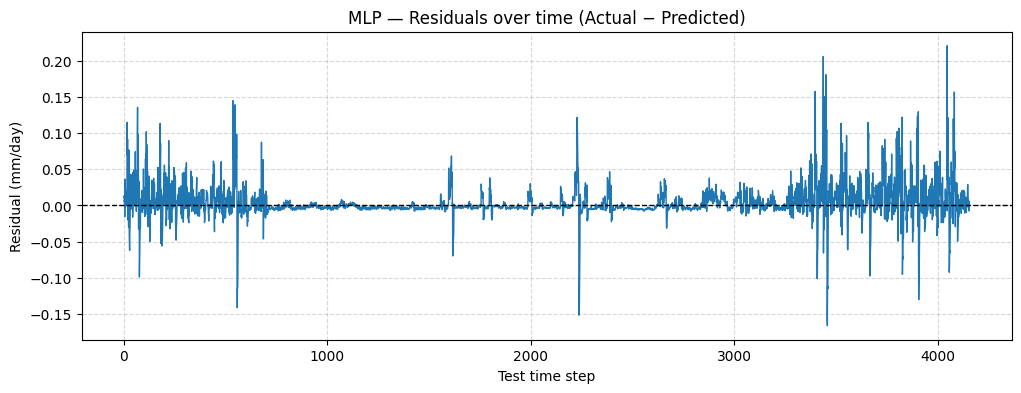

In [ ]:
import matplotlib.pyplot as plt

y_true, res = residuals["MLP"]
plt.figure(figsize=(12,4))
plt.plot(res, linewidth=1)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("MLP — Residuals over time (Actual − Predicted)")
plt.xlabel("Test time step")
plt.ylabel("Residual (mm/day)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


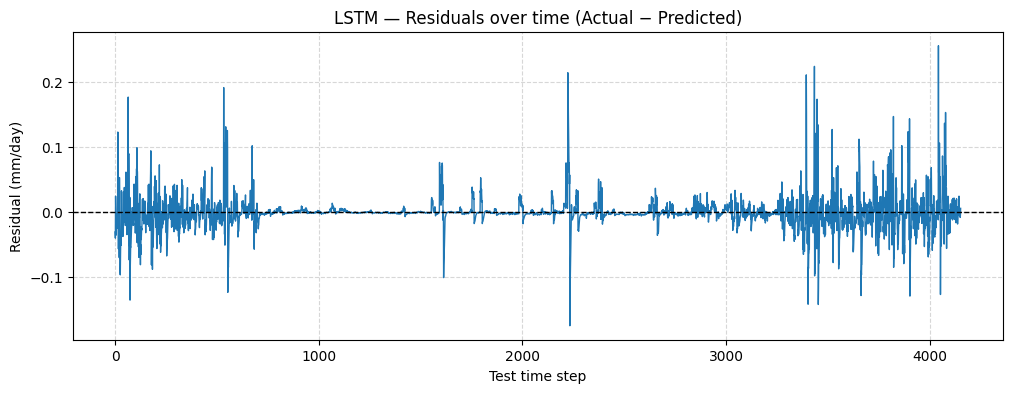

In [ ]:
y_true, res = residuals["LSTM"]
plt.figure(figsize=(12,4))
plt.plot(res, linewidth=1)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("LSTM — Residuals over time (Actual − Predicted)")
plt.xlabel("Test time step")
plt.ylabel("Residual (mm/day)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


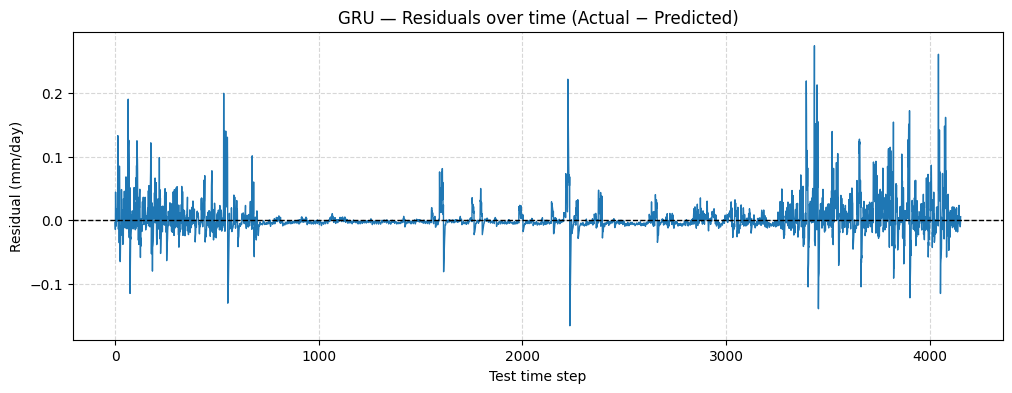

In [ ]:
y_true, res = residuals["GRU"]
plt.figure(figsize=(12,4))
plt.plot(res, linewidth=1)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("GRU — Residuals over time (Actual − Predicted)")
plt.xlabel("Test time step")
plt.ylabel("Residual (mm/day)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


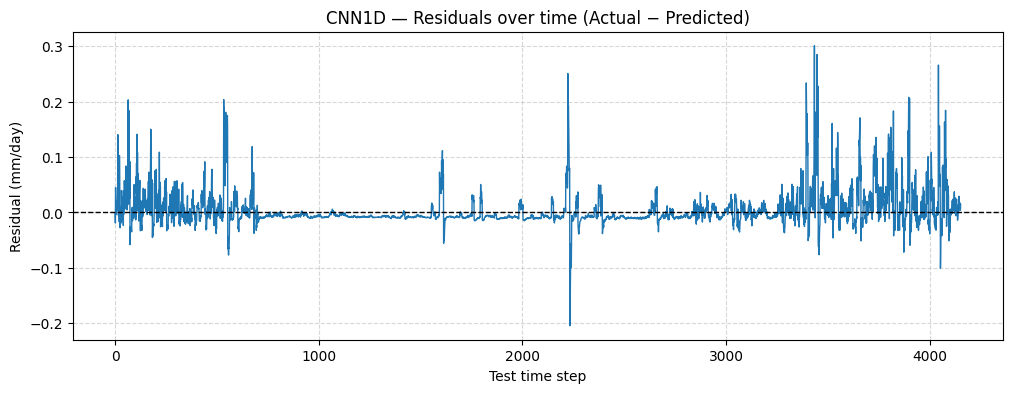

In [ ]:
y_true, res = residuals["CNN1D"]
plt.figure(figsize=(12,4))
plt.plot(res, linewidth=1)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("CNN1D — Residuals over time (Actual − Predicted)")
plt.xlabel("Test time step")
plt.ylabel("Residual (mm/day)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


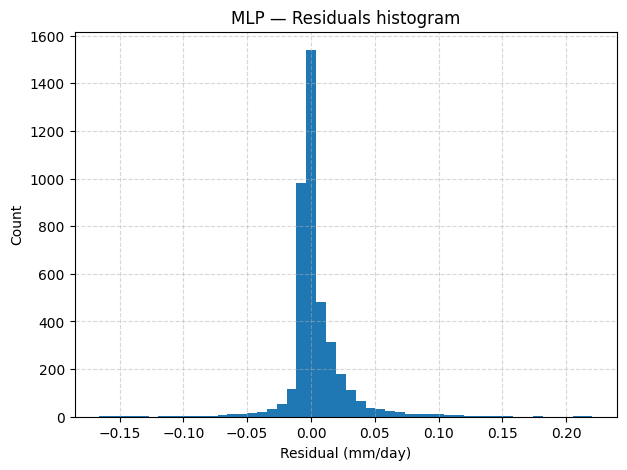

In [ ]:
y_true, res = residuals["MLP"]
plt.figure(figsize=(7,5))
plt.hist(res, bins=50)
plt.title("MLP — Residuals histogram")
plt.xlabel("Residual (mm/day)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


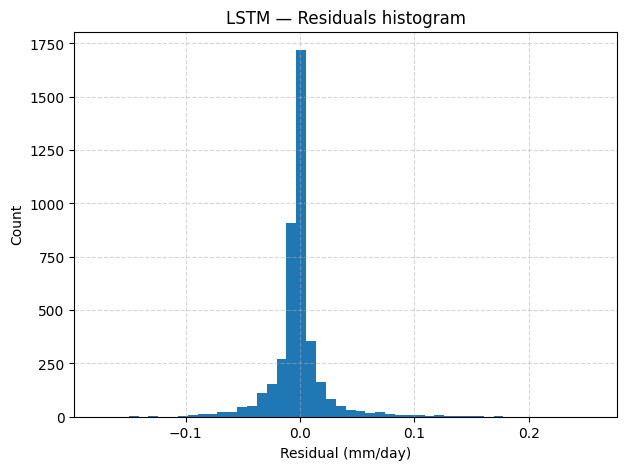

In [ ]:
y_true, res = residuals["LSTM"]
plt.figure(figsize=(7,5))
plt.hist(res, bins=50)
plt.title("LSTM — Residuals histogram")
plt.xlabel("Residual (mm/day)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


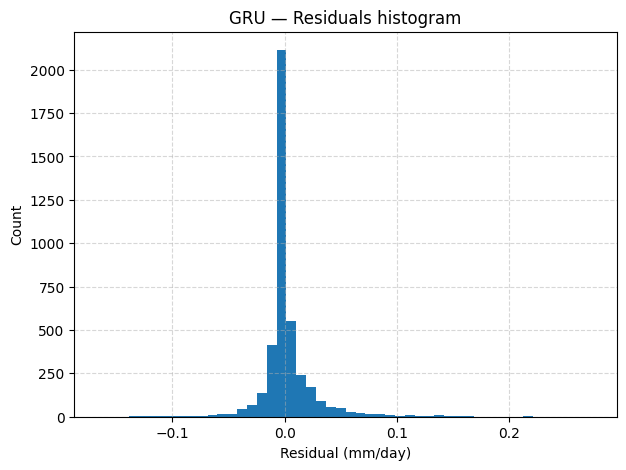

In [ ]:
y_true, res = residuals["GRU"]
plt.figure(figsize=(7,5))
plt.hist(res, bins=50)
plt.title("GRU — Residuals histogram")
plt.xlabel("Residual (mm/day)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


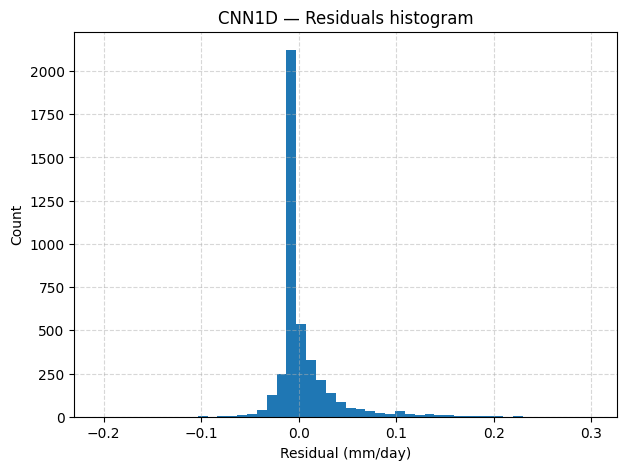

In [ ]:
y_true, res = residuals["CNN1D"]
plt.figure(figsize=(7,5))
plt.hist(res, bins=50)
plt.title("CNN1D — Residuals histogram")
plt.xlabel("Residual (mm/day)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

rows = []
for name, (y_true, res) in residuals.items():
    rows.append({
        "Model": name,
        "Residual Mean": float(np.mean(res)),
        "Residual Std": float(np.std(res)),
        "Residual Median": float(np.median(res)),
        "Residual IQR": float(np.percentile(res,75) - np.percentile(res,25))
    })
pd.DataFrame(rows)


,Model,Residual Mean,Residual Std,Residual Median,Residual IQR
0,MLP,0.003781,0.023150,-0.001418,0.012494
1,LSTM,-0.001411,0.025026,-0.001941,0.007858
2,GRU,0.002464,0.026034,-0.002067,0.010193
3,CNN1D,0.004162,0.032264,-0.006281,0.017250


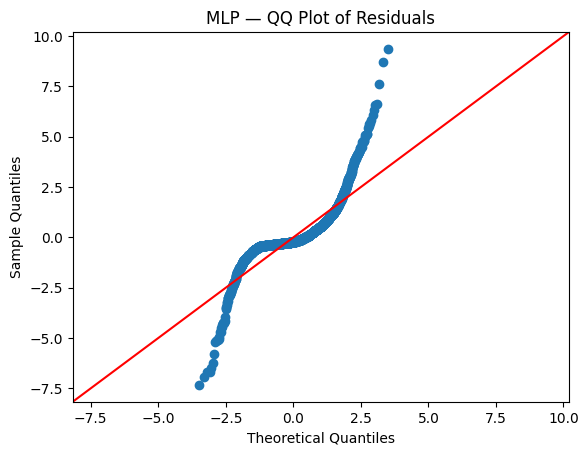

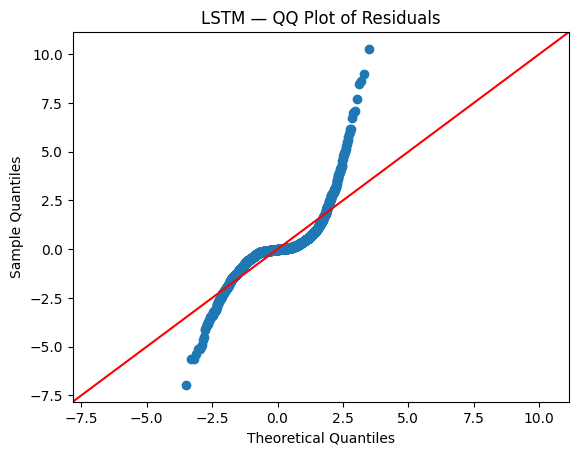

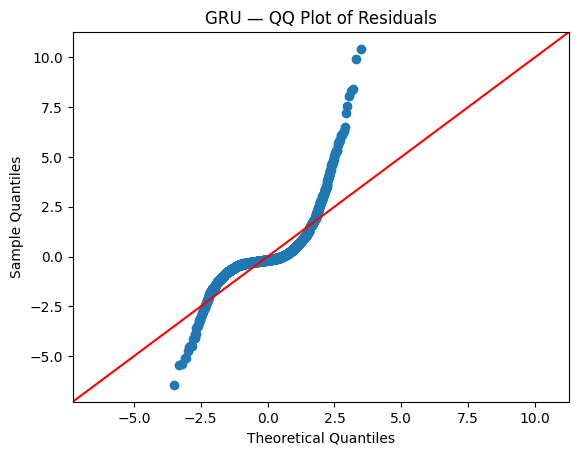

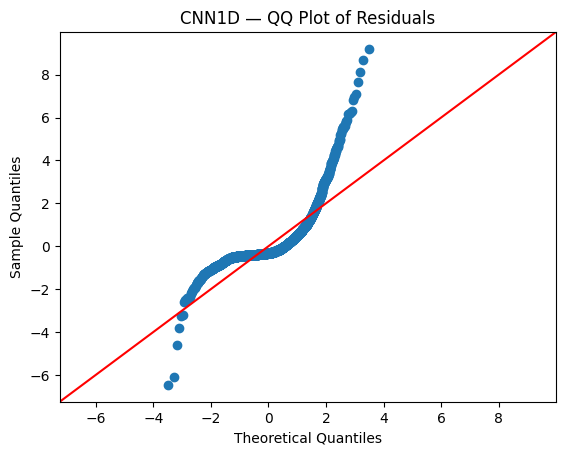

In [ ]:
import statsmodels.api as sm

for name, (y_true, res) in residuals.items():
    sm.qqplot(res, line='45', fit=True)
    plt.title(f"{name} — QQ Plot of Residuals")
    plt.show()


<Figure size 800x400 with 0 Axes>

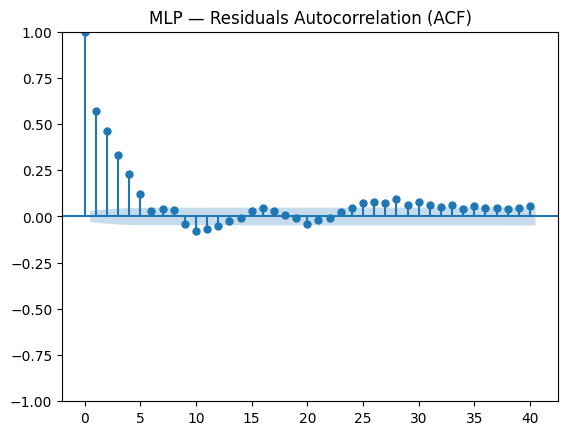

<Figure size 800x400 with 0 Axes>

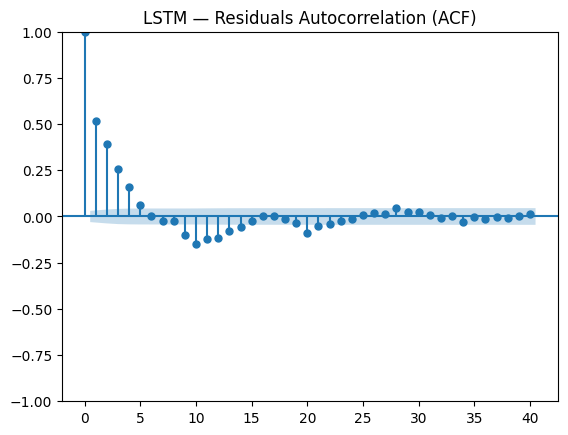

<Figure size 800x400 with 0 Axes>

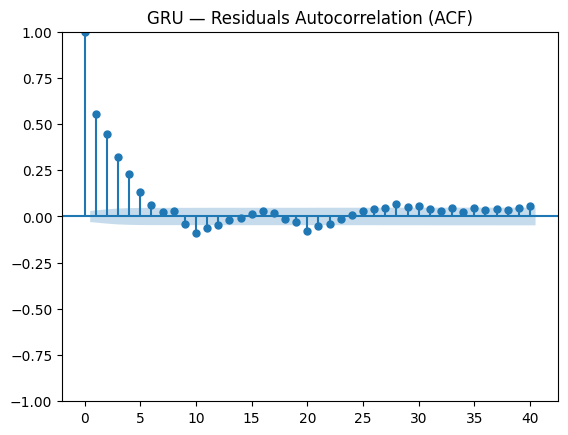

<Figure size 800x400 with 0 Axes>

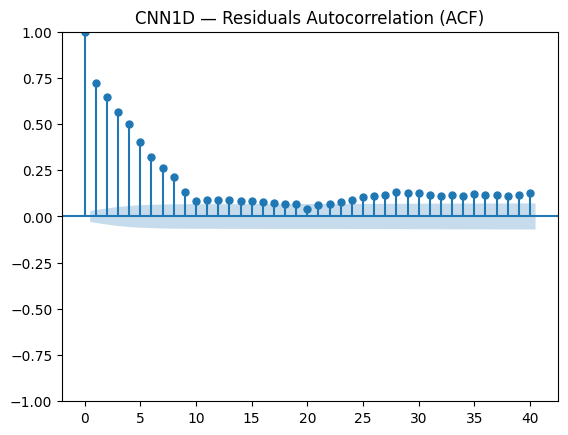

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

for name, (y_true, res) in residuals.items():
    plt.figure(figsize=(8,4))
    plot_acf(res, lags=40, alpha=0.05)
    plt.title(f"{name} — Residuals Autocorrelation (ACF)")
    plt.show()


In [ ]:
import os
os.makedirs("figures", exist_ok=True)

In [ ]:
# Distribution of Precipitation
plt.figure(figsize=(8,5))
sns.histplot(df["tp_mm"], bins=50, kde=True, color="blue")
plt.title("Distribution of Daily Precipitation (mm)")
plt.xlabel("Precipitation (mm/day)")
plt.ylabel("Frequency")
plt.savefig("figures/distribution_precip.png", dpi=300, bbox_inches="tight")
plt.close()

# Distribution of Pressure
plt.figure(figsize=(8,5))
sns.histplot(df["press_mean"], bins=50, kde=True, color="red")
plt.title("Distribution of Daily Surface Pressure (Pa)")
plt.xlabel("Surface Pressure (Pa)")
plt.ylabel("Frequency")
plt.savefig("figures/distribution_pressure.png", dpi=300, bbox_inches="tight")
plt.close()

# Monthly trends
monthly = df.resample("M").mean()

plt.figure(figsize=(10,5))
monthly["tp_mm"].plot(color="blue", linewidth=2)
plt.title("Monthly Mean Precipitation")
plt.ylabel("mm/day")
plt.savefig("figures/monthly_precip.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(10,5))
monthly["press_mean"].plot(color="red", linewidth=2)
plt.title("Monthly Mean Surface Pressure")
plt.ylabel("Pa")
plt.savefig("figures/monthly_pressure.png", dpi=300, bbox_inches="tight")
plt.close()

# Correlation heatmap
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.savefig("figures/corr_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()


In [ ]:
# MAE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["MAE"], color="skyblue")
plt.title("Model Comparison - MAE")
plt.ylabel("Mean Absolute Error")
plt.savefig("figures/mae_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# RMSE
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["RMSE"], color="salmon")
plt.title("Model Comparison - RMSE")
plt.ylabel("Root Mean Squared Error")
plt.savefig("figures/rmse_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# R²
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["R2"], color="lightgreen")
plt.title("Model Comparison - R² Score")
plt.ylabel("R²")
plt.ylim(0,1)
plt.savefig("figures/r2_bar.png", dpi=300, bbox_inches="tight")
plt.close()


In [ ]:
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.graphics.tsaplots import plot_acf

# # --- Setup ---
# # Save directly into your Drive project folder
# FIG_DIR = "/content/drive/MyDrive/Colab Notebooks/figures"
# os.makedirs(FIG_DIR, exist_ok=True)


# # Ensure datetime index for resampling
# df["time"] = pd.to_datetime(df["time"], errors="coerce")
# df = df.set_index("time")

# # =============================
# # 1. EDA Plots
# # =============================

# # Distribution of Precipitation
# plt.figure(figsize=(8,5))
# sns.histplot(df["tp_mm"], bins=50, kde=True, color="blue")
# plt.title("Distribution of Daily Precipitation (mm)")
# plt.xlabel("Precipitation (mm/day)")
# plt.ylabel("Frequency")
# plt.savefig("figures/distribution_precip.png", dpi=300, bbox_inches="tight")
# plt.close()

# # Distribution of Pressure
# plt.figure(figsize=(8,5))
# sns.histplot(df["press_mean"], bins=50, kde=True, color="red")
# plt.title("Distribution of Daily Surface Pressure (Pa)")
# plt.xlabel("Surface Pressure (Pa)")
# plt.ylabel("Frequency")
# plt.savefig("figures/distribution_pressure.png", dpi=300, bbox_inches="tight")
# plt.close()

# # Monthly trends
# monthly = df.resample("M").mean()

# plt.figure(figsize=(10,5))
# monthly["tp_mm"].plot(color="blue", linewidth=2)
# plt.title("Monthly Mean Precipitation")
# plt.ylabel("mm/day")
# plt.savefig("figures/monthly_precip.png", dpi=300, bbox_inches="tight")
# plt.close()

# plt.figure(figsize=(10,5))
# monthly["press_mean"].plot(color="red", linewidth=2)
# plt.title("Monthly Mean Surface Pressure")
# plt.ylabel("Pa")
# plt.savefig("figures/monthly_pressure.png", dpi=300, bbox_inches="tight")
# plt.close()

# # Correlation heatmap
# corr = df.corr()
# plt.figure(figsize=(12,10))
# sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
# plt.title("Feature Correlation Heatmap")
# plt.savefig("figures/corr_heatmap.png", dpi=300, bbox_inches="tight")
# plt.close()

# # =============================
# # 2. Metrics Bar Plots
# # =============================
# plt.figure(figsize=(7,5))
# plt.bar(df_results["Model"], df_results["MAE"], color="skyblue")
# plt.title("Model Comparison - MAE")
# plt.ylabel("Mean Absolute Error")
# plt.savefig("figures/mae_bar.png", dpi=300, bbox_inches="tight")
# plt.close()

# plt.figure(figsize=(7,5))
# plt.bar(df_results["Model"], df_results["RMSE"], color="salmon")
# plt.title("Model Comparison - RMSE")
# plt.ylabel("Root Mean Squared Error")
# plt.savefig("figures/rmse_bar.png", dpi=300, bbox_inches="tight")
# plt.close()

# plt.figure(figsize=(7,5))
# plt.bar(df_results["Model"], df_results["R2"], color="lightgreen")
# plt.title("Model Comparison - R² Score")
# plt.ylabel("R²")
# plt.ylim(0,1)
# plt.savefig("figures/r2_bar.png", dpi=300, bbox_inches="tight")
# plt.close()

# # =============================
# # 3. Predictions vs Actual (example: MLP)
# # =============================
# plt.figure(figsize=(12,4))
# plt.plot(y_test[:200], label="Actual", color="blue")
# plt.plot(y_pred_mlp[:200], label="Predicted", color="red", alpha=0.7)
# plt.title("MLP - Actual vs Predicted (first 200 test days)")
# plt.xlabel("Time step")
# plt.ylabel("Precipitation (mm/day)")
# plt.legend()
# plt.savefig("figures/mlp_timeseries.png", dpi=300, bbox_inches="tight")
# plt.close()

# plt.figure(figsize=(5,5))
# plt.scatter(y_test, y_pred_mlp, alpha=0.5, color="purple")
# min_val = min(y_test.min(), y_pred_mlp.min())
# max_val = max(y_test.max(), y_pred_mlp.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
# plt.title("MLP - Actual vs Predicted Scatter")
# plt.xlabel("Actual Precipitation (mm/day)")
# plt.ylabel("Predicted Precipitation (mm/day)")
# plt.savefig("figures/mlp_scatter.png", dpi=300, bbox_inches="tight")
# plt.close()

# # (Repeat same code for LSTM, GRU, CNN1D by swapping predictions)

# # =============================
# # 4. Residual Analysis (example: GRU)
# # =============================
# res = y_test_seq - y_pred_gru
# plt.figure(figsize=(7,5))
# plt.hist(res, bins=50, color="gray")
# plt.title("GRU - Residual Histogram")
# plt.xlabel("Residual (mm/day)")
# plt.ylabel("Count")
# plt.savefig("figures/gru_resid_hist.png", dpi=300, bbox_inches="tight")
# plt.close()

# plt.figure(figsize=(8,4))
# plot_acf(res, lags=40, alpha=0.05)
# plt.title("GRU - Residuals Autocorrelation (ACF)")
# plt.savefig("figures/gru_resid_acf.png", dpi=300, bbox_inches="tight")
# plt.close()

# # (Repeat for other models)


In [ ]:
# ===== Save ALL plots to Google Drive =====

import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# ---------- Configure Drive output folder ----------
FIG_DIR = "/content/drive/MyDrive/Colab Notebooks/rainfall_paper/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- Ensure time is a DatetimeIndex for resampling ----------
if "time" not in df.columns:
    df = df.reset_index()  # bring back 'time' if currently the index

df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.set_index("time").sort_index()

# =============================
# 1) EDA
# =============================

# Distribution: Precipitation
plt.figure(figsize=(8,5))
sns.histplot(df["tp_mm"], bins=50, kde=True)
plt.title("Distribution of Daily Precipitation (mm)")
plt.xlabel("Precipitation (mm/day)")
plt.ylabel("Frequency")
plt.savefig(f"{FIG_DIR}/distribution_precip.png", dpi=300, bbox_inches="tight")
plt.close()

# Distribution: Pressure
plt.figure(figsize=(8,5))
sns.histplot(df["press_mean"], bins=50, kde=True)
plt.title("Distribution of Daily Surface Pressure (Pa)")
plt.xlabel("Surface Pressure (Pa)")
plt.ylabel("Frequency")
plt.savefig(f"{FIG_DIR}/distribution_pressure.png", dpi=300, bbox_inches="tight")
plt.close()

# Monthly means
monthly = df.resample("M").mean()

plt.figure(figsize=(10,5))
monthly["tp_mm"].plot(linewidth=2)
plt.title("Monthly Mean Precipitation")
plt.ylabel("mm/day")
plt.savefig(f"{FIG_DIR}/monthly_precip.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(10,5))
monthly["press_mean"].plot(linewidth=2)
plt.title("Monthly Mean Surface Pressure")
plt.ylabel("Pa")
plt.savefig(f"{FIG_DIR}/monthly_pressure.png", dpi=300, bbox_inches="tight")
plt.close()

# Correlation heatmap
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.savefig(f"{FIG_DIR}/corr_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()

# =============================
# 2) Metrics bar plots (assumes df_results with Model/MAE/RMSE/R2 exists)
# =============================
plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["MAE"])
plt.title("Model Comparison - MAE")
plt.ylabel("Mean Absolute Error")
plt.savefig(f"{FIG_DIR}/mae_bar.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["RMSE"])
plt.title("Model Comparison - RMSE")
plt.ylabel("Root Mean Squared Error")
plt.savefig(f"{FIG_DIR}/rmse_bar.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,5))
plt.bar(df_results["Model"], df_results["R2"])
plt.title("Model Comparison - R² Score")
plt.ylabel("R²")
plt.ylim(0,1)
plt.savefig(f"{FIG_DIR}/r2_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# =============================
# 3) Predictions vs Actual (example: MLP)
# =============================
plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred_mlp[:200], label="Predicted", alpha=0.7)
plt.title("MLP - Actual vs Predicted (first 200 test days)")
plt.xlabel("Time step")
plt.ylabel("Precipitation (mm/day)")
plt.legend()
plt.savefig(f"{FIG_DIR}/mlp_timeseries.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
mn = min(float(np.min(y_test)), float(np.min(y_pred_mlp)))
mx = max(float(np.max(y_test)), float(np.max(y_pred_mlp)))
plt.plot([mn, mx], [mn, mx], 'k--', lw=2)
plt.title("MLP - Actual vs Predicted Scatter")
plt.xlabel("Actual Precipitation (mm/day)")
plt.ylabel("Predicted Precipitation (mm/day)")
plt.savefig(f"{FIG_DIR}/mlp_scatter.png", dpi=300, bbox_inches="tight")
plt.close()

# (Repeat with y_pred_lstm / y_pred_gru / y_pred_cnn if you want separate files)

# =============================
# 4) Residuals (example: GRU)
# =============================
res_gru = y_test_seq - y_pred_gru

plt.figure(figsize=(7,5))
plt.hist(res_gru, bins=50)
plt.title("GRU - Residual Histogram")
plt.xlabel("Residual (mm/day)")
plt.ylabel("Count")
plt.savefig(f"{FIG_DIR}/gru_resid_hist.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(8,4))
plot_acf(res_gru, lags=40, alpha=0.05)
plt.title("GRU - Residuals Autocorrelation (ACF)")
plt.savefig(f"{FIG_DIR}/gru_resid_acf.png", dpi=300, bbox_inches="tight")
plt.close()


<Figure size 800x400 with 0 Axes>

In [ ]:
# === Save two figures required by LaTeX ===
#   - figures/mlp_timeseries.png
#   - figures/gru_scatter.png

import os, numpy as np, matplotlib.pyplot as plt

FIG_DIR = "/content/drive/MyDrive/Colab Notebooks/rainfall_paper/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- MLP: timeseries (first 200 test steps) ----------
# Tries to reuse y_pred_mlp; if missing, predicts using mlp_model + X_test_sc
if 'y_test' not in globals():
    raise RuntimeError("y_test not found. Please run your train/test split cell again.")

if 'y_pred_mlp' not in globals():
    if 'mlp_model' in globals() and 'X_test_sc' in globals():
        y_pred_mlp = mlp_model.predict(X_test_sc).ravel()
    else:
        raise RuntimeError("y_pred_mlp not found and cannot recompute because mlp_model/X_test_sc are missing. Re-run the MLP block first.")

plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred_mlp[:200], label="Predicted", alpha=0.7)
plt.title("MLP - Actual vs Predicted (first 200 test steps)")
plt.xlabel("Time step")
plt.ylabel("Precipitation (mm/day)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f"{FIG_DIR}/mlp_timeseries.png", dpi=300, bbox_inches="tight")
plt.close()

# ---------- GRU: scatter ----------
# Tries to reuse y_pred_gru; if missing, predicts using gru_model + X_test_seq
if 'y_test_seq' not in globals():
    raise RuntimeError("y_test_seq not found. Please run the sequence-prep split for LSTM/GRU again.")

if 'y_pred_gru' not in globals():
    if 'gru_model' in globals() and 'X_test_seq' in globals():
        y_pred_gru = gru_model.predict(X_test_seq).ravel()
    else:
        raise RuntimeError("y_pred_gru not found and cannot recompute because gru_model/X_test_seq are missing. Re-run the GRU block first.")

plt.figure(figsize=(5,5))
plt.scatter(y_test_seq, y_pred_gru, alpha=0.5)
mn = float(min(np.min(y_test_seq), np.min(y_pred_gru)))
mx = float(max(np.max(y_test_seq), np.max(y_pred_gru)))
plt.plot([mn, mx], [mn, mx], 'k--', lw=2)
plt.title("GRU - Actual vs Predicted Scatter")
plt.xlabel("Actual Precipitation (mm/day)")
plt.ylabel("Predicted Precipitation (mm/day)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f"{FIG_DIR}/gru_scatter.png", dpi=300, bbox_inches="tight")
plt.close()

print("Saved:",
      f"\n- {FIG_DIR}/mlp_timeseries.png",
      f"\n- {FIG_DIR}/gru_scatter.png")


Saved: 
- /content/drive/MyDrive/Colab Notebooks/rainfall_paper/figures/mlp_timeseries.png 
- /content/drive/MyDrive/Colab Notebooks/rainfall_paper/figures/gru_scatter.png


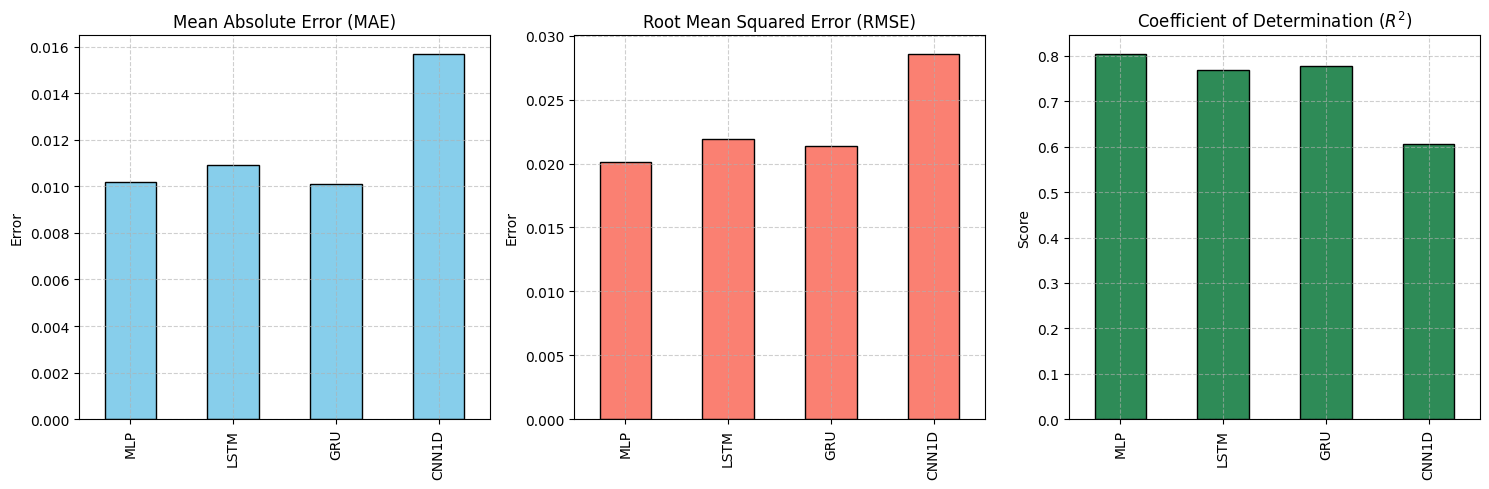

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Your evaluation results (from earlier runs)
metrics = {
    "MLP":   {"MAE": 0.0102, "RMSE": 0.0201, "R2": 0.805},
    "LSTM":  {"MAE": 0.0109, "RMSE": 0.0219, "R2": 0.769},
    "GRU":   {"MAE": 0.0101, "RMSE": 0.0214, "R2": 0.779},
    "CNN1D": {"MAE": 0.0157, "RMSE": 0.0286, "R2": 0.606},
}

df_metrics = pd.DataFrame(metrics).T  # Models as rows

# Plot grouped bar chart
fig, axes = plt.subplots(1, 3, figsize=(15,5))

df_metrics["MAE"].plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("Error")

df_metrics["RMSE"].plot(kind="bar", ax=axes[1], color="salmon", edgecolor="black")
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("Error")

df_metrics["R2"].plot(kind="bar", ax=axes[2], color="seagreen", edgecolor="black")
axes[2].set_title("Coefficient of Determination ($R^2$)")
axes[2].set_ylabel("Score")

for ax in axes:
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("figures/metrics_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


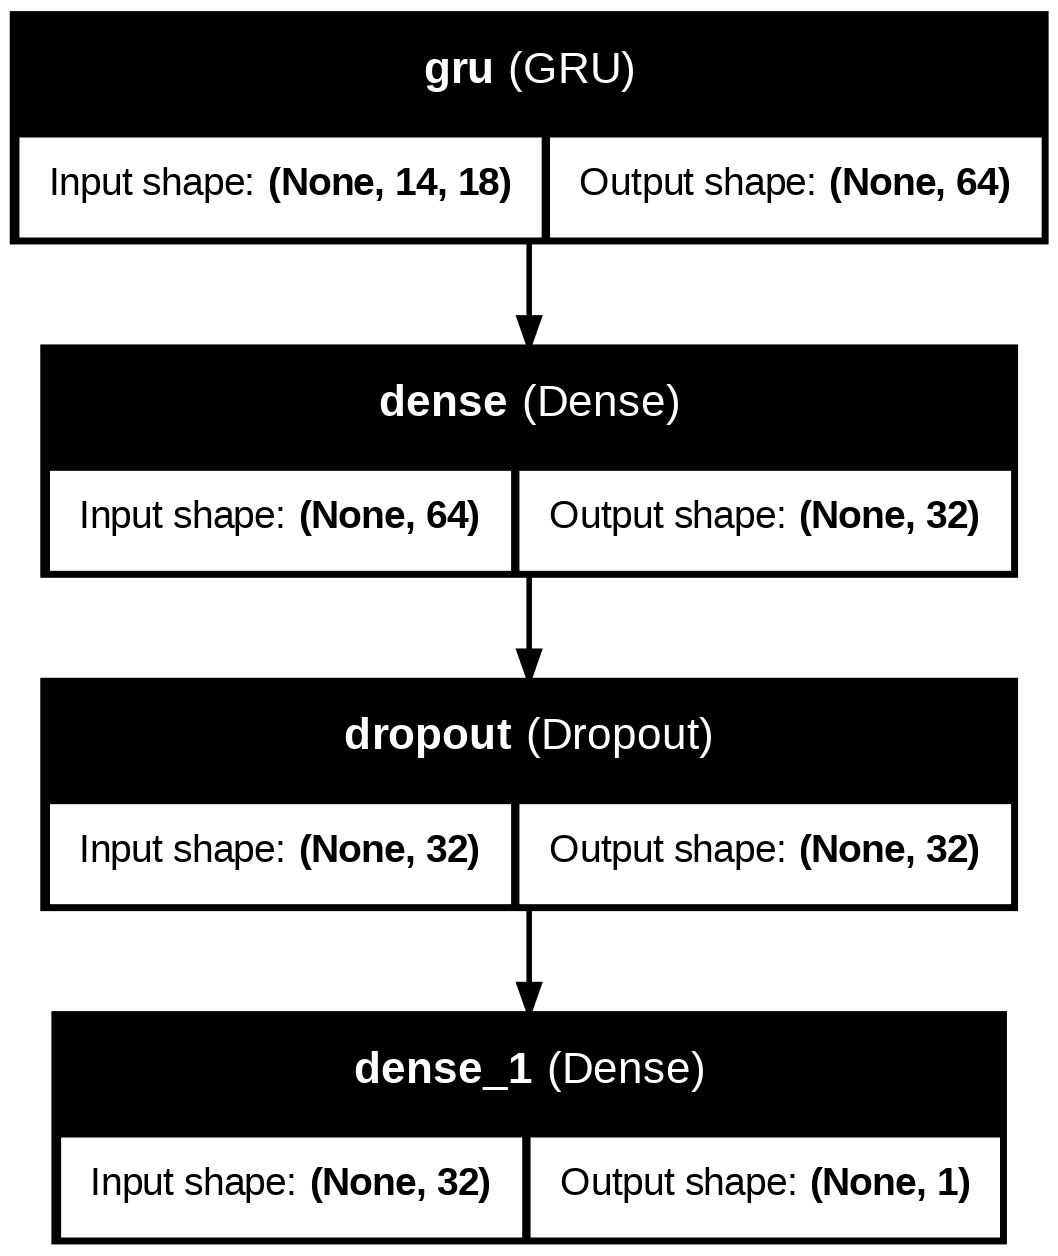

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model

# Adjust input_dim = number of features in your dataset (replace 18 if different)
n_features = 18

# Define GRU model exactly as in your paper
gru_model = Sequential([
    GRU(64, input_shape=(14, n_features)),   # 14 days, n_features predictors
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)   # Output: daily rainfall
])

# Save architecture diagram as PNG
plot_model(
    gru_model,
    to_file="gru_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=200
)
